## Jeopardy NLTK Word Cloud & TF- IDF Analysis

In [1]:
#Import dependencies
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.decomposition import NMF

path = ('./Resources/QuestionsSQL.csv')


In [2]:
questions_csv = pd.read_csv(path).drop(columns = 'Unnamed: 0')

In [3]:
questions_csv

,game_id,question_text,answer,category
0,3901,"A longshot who wins, or a ""Star Wars"" comic bo...",a dark horse,"""DAR"""
1,3901,"A term of endearment, like for my Clementine",darling,"""DAR"""
2,3901,It's the Turkish strait seen here,the Dardanelles,"""DAR"""
3,3901,The inner bull's eye is commonly worth 50 poin...,darts,"""DAR"""
4,3901,This capital of Australia's Northern Territory...,Darwin,"""DAR"""
...,...,...,...,...
49890,4385,Alexander Solzhenitsyn spent years in the Gula...,Stalin,WRITERS IN PRISON
49891,4385,"An author, statesman & saint, he was jailed in...",Thomas More,WRITERS IN PRISON
49892,4385,He spent 30 days in jail for vagrancy in 1894 ...,Jack London,WRITERS IN PRISON
49893,4385,"The ""idiot""! He got mixed up with the Petrashe...",Dostoyevsky,WRITERS IN PRISON


## NLTK processes to tokenize bag of words from Jeopardy Data

In [4]:
# let joins all the title rows and tokenize them into words
questions =" ".join(questions_csv['question_text'])
answers = " ".join(questions_csv['answer'])
categories = " ".join(questions_csv['category'])
question_words = word_tokenize(questions)
answer_words = word_tokenize(answers)
category_words = word_tokenize(categories)

In [5]:
#Create a function to iterate through data, normalize the data, remove all stopwords,
# and produce lemmas (basic form of words)
def clean_words(new_tokens):
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    return new_tokens

In [6]:
question_word_freq = clean_words(question_words)
answer_word_freq = clean_words(answer_words)
category_word_freq = clean_words(category_words)

In [7]:
#Create a count of common words found in Jeopardy questions, answers, and categories
question_freq = Counter(question_word_freq)

In [8]:
answer_freq = Counter(answer_word_freq)

In [9]:
category_freq = Counter(category_word_freq)

In [10]:
#Convert enumerated word counts into dataframes
question_count_df = pd.DataFrame(question_freq.items(),columns=['Word','Count'])
answer_count_df = pd.DataFrame(answer_freq.items(),columns=['Word','Count'])
category_count_df = pd.DataFrame(category_freq.items(),columns=['Word','Count'])


In [11]:
#Explored dataframes to ensure no null values existed
question_count_df.sort_values(by = 'Count', ascending = False)

question_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39529 entries, 0 to 39528
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    39529 non-null  object
 1   Count   39529 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 617.8+ KB


In [12]:
answer_count_df.sort_values(by =['Count'], ascending = False)

answer_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19705 entries, 0 to 19704
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    19705 non-null  object
 1   Count   19705 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 308.0+ KB


In [13]:
#Wrote dataframes to *.CSV for further analysis
question_count_df.to_csv('question_count_NLTK.csv')
answer_count_df.to_csv('answer_count_NLTK.csv')
category_count_df.to_csv('category_count_NLTK.csv')


In [14]:
#Converted dataframe to a dicitionary of tuples for processing by WordCloud
data_Cat = dict(category_count_df[['Word', 'Count']].itertuples(index=False, name=None))
data_Ques = dict(question_count_df[['Word', 'Count']].itertuples(index=False, name=None))
data_Ans = dict(answer_count_df[['Word', 'Count']].itertuples(index=False, name=None))



## Word Cloud Visuals

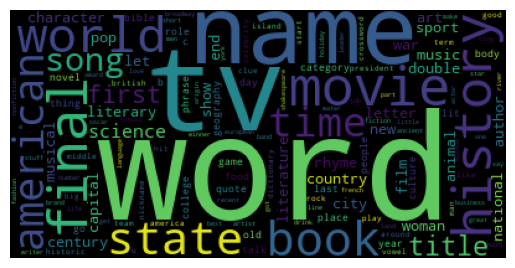

<Figure size 4000x2000 with 0 Axes>

In [15]:
#Created WordCloud Visuals for later presentation
wc_Cat = WordCloud().generate_from_frequencies(data_Cat)
wc_Cat.to_file("./Images/Category_Cloud_NLTK.png")

plt.imshow(wc_Cat)
plt.axis('off')
plt.figure( figsize=(40,20) )
plt.show()

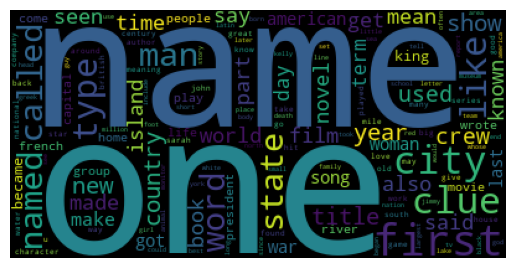

<Figure size 4000x2000 with 0 Axes>

In [16]:
wc_Cat = WordCloud().generate_from_frequencies(data_Ques)
wc_Cat.to_file("./Images/Question_Cloud_NLTK.png")

plt.imshow(wc_Cat)
plt.axis('off')
plt.figure( figsize=(40,20) )
plt.show()

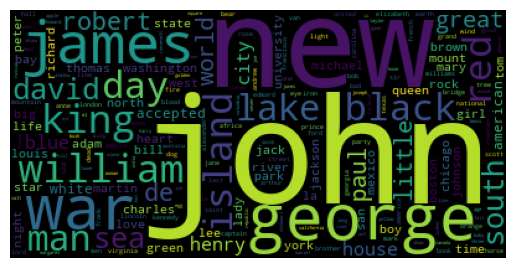

<Figure size 4000x2000 with 0 Axes>

In [17]:
wc_Cat = WordCloud().generate_from_frequencies(data_Ans)
wc_Cat.to_file("./Images/Answer_Cloud_NLTK.png")

plt.imshow(wc_Cat)
plt.axis('off')
plt.figure( figsize=(40,20) )
plt.show()

## Calculating TF-IDF Values and performing supervised machine learning to evaluate whether a Jeopardy category has a strong influence on natural language predictions


In [18]:
questions_csv

questions_csv['text'] = questions_csv['category'] + ' ' + questions_csv['question_text'] + ' ' + questions_csv['answer'].astype(str)

In [19]:
text = " ".join(questions_csv['text'])
text = word_tokenize(text)
text = clean_words(text)

In [20]:
v = TfidfVectorizer()
transformed_output = v.fit_transform(text)
print(v.vocabulary_)

{'dar': 10107, 'longshot': 23738, 'win': 44342, 'star': 38392, 'war': 43695, 'comic': 8246, 'book': 4759, 'publisher': 32167, 'dark': 10124, 'horse': 19115, 'term': 40330, 'endearment': 13106, 'like': 23330, 'clementine': 7789, 'darling': 10135, 'turkish': 41845, 'strait': 38800, 'seen': 35944, 'dardanelles': 10112, 'inner': 20290, 'bull': 5593, 'eye': 14060, 'commonly': 8310, 'worth': 44665, 'point': 31048, 'game': 16000, 'dart': 10150, 'capital': 6253, 'australia': 2620, 'northern': 27967, 'territory': 40369, 'named': 27156, 'evolutionary': 13757, 'scientist': 35631, 'darwin': 10159, 'art': 2177, 'artist': 2206, 'depicting': 10745, 'native': 27283, 'american': 1275, 'george': 16338, 'catlin': 6661, 'often': 28443, 'painted': 29306, 'beast': 3539, 'assiniboine': 2347, 'indian': 20050, 'pursuing': 32335, 'snowshoe': 37533, 'buffalo': 5546, 'impressionist': 19899, 'painter': 29307, 'father': 14331, 'jean': 21057, 'director': 11281, 'rule': 34775, 'renoir': 33628, 'thomas': 40597, 'sully

In [21]:
all_feature_names = v.get_feature_names_out(text)

for word in all_feature_names:
    index = v.vocabulary_.get(word)
    print(f'{word}, {v.idf_[index]}')

aa, 12.641818115246211
aaa, 12.459496558452257
aaaee, 13.558108847120366
aachen, 13.558108847120366
aahs, 13.558108847120366
aak, 13.558108847120366
aalenian, 13.558108847120366
aalto, 13.558108847120366
aam, 13.152643739012202
aar, 13.558108847120366
aardman, 13.558108847120366
aardvark, 12.641818115246211
aardwolf, 13.558108847120366
aaron, 10.359435729569684
aarp, 12.459496558452257
aau, 13.558108847120366
ab, 11.612198698065052
aba, 12.86496166656042
ababa, 12.641818115246211
abaca, 13.558108847120366
aback, 13.152643739012202
abactor, 13.558108847120366
abacus, 12.305345878624998
abaddon, 13.558108847120366
abamasum, 13.558108847120366
abandon, 12.459496558452257
abandoned, 11.47866730544053
abandoning, 13.558108847120366
abated, 13.558108847120366
abatement, 13.558108847120366
abba, 12.171814486000475
abbas, 13.152643739012202
abbasid, 13.558108847120366
abbe, 13.558108847120366
abbev, 12.459496558452257
abbey, 10.46706639376205
abbi, 13.558108847120366
abbie, 12.86496166656042
a

airflow, 13.558108847120366
airfoil, 13.152643739012202
airforce, 13.558108847120366
airframe, 13.152643739012202
airlift, 12.459496558452257
airline, 9.974589908664257
airliner, 12.641818115246211
airmail, 13.558108847120366
airman, 13.152643739012202
airness, 13.558108847120366
airplane, 10.537683960976004
airplay, 12.459496558452257
airport, 9.233976190865388
airship, 12.054031450344091
airshow, 13.558108847120366
airtight, 12.459496558452257
airwave, 13.558108847120366
airway, 11.686306670218775
airwolf, 13.558108847120366
airy, 13.558108847120366
aisle, 11.160213574321995
aitcheson, 13.558108847120366
aix, 13.558108847120366
ajaccio, 13.558108847120366
ajar, 13.152643739012202
ajax, 12.459496558452257
ajay, 13.558108847120366
aje, 13.558108847120366
aka, 8.913717947978993
akadimias, 13.558108847120366
akaka, 13.558108847120366
akas, 11.85336075488194
akasha, 13.558108847120366
akbar, 12.641818115246211
akc, 12.641818115246211
ake, 12.641818115246211
akebono, 13.558108847120366
ake

altarpiece, 12.86496166656042
altas, 13.558108847120366
alter, 11.073202197332366
altera, 13.558108847120366
alteration, 12.459496558452257
altered, 11.948670934686266
altering, 13.152643739012202
alternate, 11.160213574321995
alternated, 13.152643739012202
alternating, 12.459496558452257
alternative, 11.115761811751161
alternator, 13.558108847120366
alters, 13.152643739012202
althea, 13.152643739012202
althing, 13.558108847120366
although, 11.073202197332366
altima, 13.558108847120366
altitude, 11.25552375412632
altius, 13.558108847120366
altman, 13.558108847120366
alto, 12.054031450344091
altogether, 12.86496166656042
altoids, 12.86496166656042
alton, 12.86496166656042
altostratus, 13.558108847120366
altria, 13.558108847120366
altruistic, 13.558108847120366
alum, 11.5432058265781
aluminum, 11.5432058265781
alumna, 13.558108847120366
alumnus, 10.883960197693836
alva, 13.152643739012202
alvan, 13.152643739012202
alvar, 13.558108847120366
alvares, 13.558108847120366
alvarez, 13.55810884

archer, 10.99315948965883
archery, 12.459496558452257
archetype, 13.152643739012202
archie, 11.206733589956889
archies, 13.558108847120366
archimedes, 12.171814486000475
archipelago, 10.667737089224202
architect, 10.092372944320639
architectural, 11.47866730544053
architecturally, 13.558108847120366
architecture, 10.017149523083052
archive, 11.30681704851387
archiving, 13.558108847120366
archrival, 13.558108847120366
archway, 13.558108847120366
arcing, 13.152643739012202
arco, 13.558108847120366
arctic, 10.49005591198675
arcturus, 13.152643739012202
arden, 12.459496558452257
ardennes, 13.558108847120366
ardent, 13.558108847120366
ardor, 13.558108847120366
are, 12.641818115246211
area, 8.269841816425831
areacalled, 13.558108847120366
arecibo, 13.558108847120366
arena, 11.160213574321995
aretha, 11.5432058265781
arf, 13.558108847120366
arg, 13.558108847120366
argentina, 10.140382163507
argentine, 12.171814486000475
argentinean, 13.558108847120366
argentinian, 13.558108847120366
argentino

astley, 13.558108847120366
aston, 13.152643739012202
astonishment, 13.558108847120366
astor, 12.459496558452257
astoria, 12.86496166656042
astound, 13.558108847120366
astounded, 13.558108847120366
astounding, 12.86496166656042
astra, 13.558108847120366
astral, 13.152643739012202
astrid, 12.86496166656042
astride, 13.558108847120366
astringency, 13.152643739012202
astro, 13.558108847120366
astrobleme, 13.558108847120366
astrodome, 13.152643739012202
astrolabe, 13.152643739012202
astrologer, 12.86496166656042
astrologic, 13.558108847120366
astrological, 12.641818115246211
astrology, 11.948670934686266
astromech, 13.558108847120366
astronaut, 10.955419161675982
astronautics, 13.152643739012202
astronomer, 10.359435729569684
astronomia, 13.558108847120366
astronomic, 13.558108847120366
astronomical, 10.695907966190898
astronomy, 10.785520124880584
astrophel, 13.558108847120366
astrophysicist, 12.459496558452257
astrophysics, 12.459496558452257
astros, 13.152643739012202
astroturf, 13.55810

bareilles, 12.641818115246211
barely, 11.5432058265781
bareminerals, 13.558108847120366
barenaked, 12.86496166656042
barenboim, 13.558108847120366
barents, 12.86496166656042
baretta, 13.558108847120366
barfly, 12.641818115246211
bargain, 12.305345878624998
bargaining, 13.152643739012202
barge, 12.171814486000475
barhop, 13.558108847120366
barhopping, 13.558108847120366
bariatrics, 13.558108847120366
barista, 13.152643739012202
baristas, 13.558108847120366
baritone, 12.171814486000475
bark, 11.160213574321995
barker, 12.054031450344091
barking, 12.641818115246211
barkley, 12.459496558452257
barley, 12.171814486000475
barleycorn, 13.558108847120366
barlow, 13.558108847120366
barmaid, 13.558108847120366
barn, 11.766349377892311
barnabas, 12.86496166656042
barnacle, 11.5432058265781
barnard, 12.641818115246211
barnes, 11.948670934686266
barney, 11.418042683624096
barneys, 13.558108847120366
barnstormer, 13.558108847120366
barnstorming, 13.558108847120366
barnum, 11.5432058265781
barnyard, 

bluefish, 13.558108847120366
bluegill, 13.558108847120366
bluegrass, 11.948670934686266
bluejacket, 13.558108847120366
bluenose, 13.558108847120366
blueprint, 12.641818115246211
bluer, 13.558108847120366
blueshift, 13.558108847120366
bluesman, 13.152643739012202
bluest, 12.86496166656042
bluesy, 12.305345878624998
bluetooth, 12.641818115246211
bluff, 11.85336075488194
bluffing, 13.558108847120366
bluford, 13.558108847120366
bluish, 12.86496166656042
blum, 13.558108847120366
blume, 12.459496558452257
blumenbach, 13.558108847120366
blunder, 12.171814486000475
blunderbuss, 13.558108847120366
blunderland, 13.558108847120366
blunt, 12.305345878624998
blunted, 13.558108847120366
blur, 13.558108847120366
blurb, 13.152643739012202
blurred, 12.305345878624998
blurts, 13.558108847120366
blush, 12.641818115246211
bluster, 13.558108847120366
bluth, 12.459496558452257
blutwurst, 13.558108847120366
blvd, 12.641818115246211
bly, 12.305345878624998
blynken, 13.152643739012202
blythe, 13.55810884712036

butoiul, 13.558108847120366
butt, 11.686306670218775
buttafuoco, 13.558108847120366
buttall, 13.152643739012202
butte, 12.459496558452257
butter, 10.46706639376205
butterball, 13.152643739012202
buttercup, 12.171814486000475
buttered, 13.558108847120366
butterfat, 13.558108847120366
butterfield, 13.152643739012202
butterfinger, 13.558108847120366
butterfingers, 13.152643739012202
butterfly, 10.401108425970254
butterflying, 13.558108847120366
butterhead, 13.558108847120366
buttermilk, 12.86496166656042
butternut, 12.86496166656042
butterworth, 13.558108847120366
buttery, 12.459496558452257
butthead, 13.152643739012202
butting, 13.558108847120366
buttock, 13.152643739012202
button, 10.640338115036087
buttoned, 13.152643739012202
buttonhole, 13.558108847120366
buttress, 13.152643739012202
butz, 13.558108847120366
buvos, 13.558108847120366
buxom, 13.152643739012202
buxtehude, 13.558108847120366
buy, 9.707961245410308
buyer, 11.766349377892311
buying, 11.360884269784147
buyuk, 13.5581088471

cameron, 11.30681704851387
cameroon, 12.86496166656042
cameth, 13.558108847120366
cami, 13.558108847120366
camilla, 12.86496166656042
camille, 12.459496558452257
camino, 12.86496166656042
camisole, 13.558108847120366
camlias, 13.558108847120366
cammi, 13.558108847120366
camouflage, 12.459496558452257
camp, 10.513586409396943
campagna, 13.558108847120366
campaign, 9.988576150638997
campaigned, 12.86496166656042
campaigner, 13.558108847120366
campana, 13.152643739012202
campanella, 13.558108847120366
campanelle, 13.558108847120366
campanile, 13.558108847120366
campanology, 13.558108847120366
campbell, 11.206733589956889
campechanus, 13.558108847120366
campeche, 13.558108847120366
camped, 12.86496166656042
camper, 12.641818115246211
campfire, 12.86496166656042
campground, 13.558108847120366
camping, 11.766349377892311
campo, 13.152643739012202
campobello, 13.152643739012202
campos, 13.558108847120366
camptown, 13.558108847120366
campus, 10.10812130128878
campy, 13.558108847120366
camry, 1

charmin, 12.86496166656042
charming, 12.171814486000475
charmingly, 13.558108847120366
charn, 13.558108847120366
charnel, 13.558108847120366
charny, 13.558108847120366
charo, 13.558108847120366
charon, 12.459496558452257
charoset, 13.558108847120366
charred, 13.152643739012202
charriere, 13.152643739012202
chart, 9.96079658653192
charta, 13.558108847120366
charted, 12.641818115246211
charter, 10.99315948965883
chartered, 13.152643739012202
charteris, 13.558108847120366
chartres, 13.558108847120366
chartreuse, 13.152643739012202
charwoman, 13.558108847120366
chase, 10.401108425970254
chased, 12.86496166656042
chaser, 11.85336075488194
chasing, 11.85336075488194
chasma, 13.558108847120366
chassis, 12.86496166656042
chastain, 12.86496166656042
chaste, 13.558108847120366
chastised, 13.152643739012202
chastity, 13.152643739012202
chat, 11.686306670218775
chateau, 11.948670934686266
chatelaine, 13.558108847120366
chatham, 13.558108847120366
chatoyancy, 13.558108847120366
chatroom, 13.5581088

chocolat, 13.152643739012202
chocolate, 9.86922939300643
chocolatesare, 13.558108847120366
chocolatey, 13.558108847120366
chocolatier, 12.054031450344091
chocolatl, 13.558108847120366
chocolaty, 13.558108847120366
choctaw, 13.558108847120366
chocula, 13.558108847120366
choice, 9.751446357350046
choicest, 13.152643739012202
choir, 11.948670934686266
choirmaster, 13.558108847120366
choke, 13.558108847120366
choked, 13.558108847120366
choking, 12.86496166656042
chol, 13.558108847120366
cholecystectomy, 13.558108847120366
choler, 13.152643739012202
cholera, 11.948670934686266
choleric, 13.558108847120366
cholesterol, 11.85336075488194
cholula, 13.558108847120366
chomp, 13.558108847120366
chomping, 13.558108847120366
chomsky, 13.558108847120366
chong, 12.86496166656042
choo, 12.86496166656042
choose, 11.360884269784147
chooser, 13.558108847120366
chooses, 12.305345878624998
choosing, 12.459496558452257
choosy, 12.459496558452257
chop, 12.171814486000475
chopin, 11.47866730544053
chopped, 12

complicity, 13.558108847120366
compliment, 12.86496166656042
complimentary, 12.641818115246211
complimenting, 13.558108847120366
comply, 13.558108847120366
component, 11.360884269784147
compose, 12.641818115246211
composed, 10.319430394955985
composer, 8.952938661132276
composes, 13.558108847120366
composing, 12.86496166656042
composite, 12.305345878624998
composition, 11.25552375412632
compost, 11.686306670218775
composting, 13.558108847120366
composure, 13.558108847120366
compote, 12.305345878624998
compound, 9.666288549009739
comprehend, 12.86496166656042
comprehended, 13.558108847120366
comprehension, 13.558108847120366
compress, 12.86496166656042
compressed, 12.171814486000475
compression, 12.86496166656042
compressor, 13.558108847120366
comprises, 12.459496558452257
compromise, 11.766349377892311
compromised, 13.558108847120366
compromiser, 13.558108847120366
compromising, 13.558108847120366
compson, 12.86496166656042
compton, 12.054031450344091
compulsion, 13.558108847120366
com

cubist, 12.641818115246211
cubit, 12.86496166656042
cucaracha, 13.558108847120366
cuckold, 13.558108847120366
cuckoo, 11.948670934686266
cucumber, 12.054031450344091
cud, 13.152643739012202
cuddalore, 13.558108847120366
cuddly, 13.558108847120366
cudgel, 13.558108847120366
cue, 11.766349377892311
cuellar, 13.558108847120366
cuernavaca, 13.558108847120366
cuervo, 12.86496166656042
cuervos, 13.558108847120366
cueva, 13.558108847120366
cuff, 12.641818115246211
cuffed, 13.558108847120366
cugat, 13.558108847120366
cuiaba, 13.558108847120366
cuilcagh, 13.558108847120366
cuisine, 10.667737089224202
cuisse, 13.558108847120366
cujo, 13.152643739012202
cukor, 13.558108847120366
culicidae, 13.558108847120366
culinary, 12.459496558452257
culkin, 13.152643739012202
cull, 13.558108847120366
culled, 13.558108847120366
cullen, 12.459496558452257
cullera, 13.558108847120366
cullinan, 11.686306670218775
culling, 13.558108847120366
culloden, 12.86496166656042
culminate, 13.558108847120366
culminated, 13.

devi, 13.558108847120366
deviate, 13.558108847120366
deviation, 12.641818115246211
device, 9.163659692447927
devil, 9.740396521163461
deviled, 12.641818115246211
devilish, 11.766349377892311
devilishly, 13.152643739012202
devilles, 13.558108847120366
devious, 13.152643739012202
devise, 12.86496166656042
devised, 11.948670934686266
devito, 12.86496166656042
devo, 12.86496166656042
devoid, 13.558108847120366
devon, 12.054031450344091
devonian, 13.558108847120366
devonshire, 13.558108847120366
devota, 13.558108847120366
devote, 13.558108847120366
devoted, 10.46706639376205
devotedly, 13.558108847120366
devotee, 12.86496166656042
devotes, 13.558108847120366
devoting, 13.558108847120366
devotion, 11.948670934686266
devotional, 12.86496166656042
devour, 13.558108847120366
devoured, 13.558108847120366
devout, 13.558108847120366
devries, 13.558108847120366
dew, 12.459496558452257
dewar, 11.686306670218775
dewdrop, 13.558108847120366
dewey, 10.72489550306415
dewhurst, 13.558108847120366
dewitt,

duhamel, 13.152643739012202
dujardin, 13.558108847120366
dukakis, 12.641818115246211
duke, 9.532757156385216
dukedom, 13.558108847120366
dulce, 13.558108847120366
dulcet, 13.558108847120366
dulcimer, 13.558108847120366
dulcinea, 13.558108847120366
dulcis, 13.558108847120366
dull, 11.418042683624096
dulled, 13.558108847120366
dulles, 12.171814486000475
dullness, 13.558108847120366
dulse, 13.558108847120366
duluth, 13.558108847120366
dum, 12.171814486000475
duma, 11.360884269784147
dumb, 11.418042683624096
dumbarton, 13.558108847120366
dumbbell, 13.558108847120366
dumbella, 13.558108847120366
dumber, 13.152643739012202
dumbfounded, 13.558108847120366
dumbledore, 13.152643739012202
dumbo, 12.459496558452257
dumbstruck, 13.558108847120366
dummy, 12.171814486000475
dumont, 13.152643739012202
dump, 11.686306670218775
dumped, 13.152643739012202
dumping, 13.152643739012202
dumpling, 12.171814486000475
dumpster, 13.558108847120366
dumpty, 12.86496166656042
dun, 13.558108847120366
dunant, 13.558

ersatz, 13.558108847120366
erskine, 12.86496166656042
ertegun, 13.558108847120366
erudite, 13.152643739012202
erupt, 13.558108847120366
erupted, 12.054031450344091
eruption, 11.47866730544053
erupts, 13.152643739012202
ervin, 13.152643739012202
erving, 13.558108847120366
erwin, 12.171814486000475
erything, 12.459496558452257
es, 12.459496558452257
esa, 13.152643739012202
esau, 12.171814486000475
escalade, 13.152643739012202
escalante, 13.558108847120366
escalated, 13.558108847120366
escalier, 13.558108847120366
escape, 9.92052268739398
escaped, 11.206733589956889
escapee, 13.558108847120366
escaping, 12.459496558452257
escapologist, 13.558108847120366
escapology, 13.558108847120366
escargot, 12.86496166656042
escarlata, 13.558108847120366
escarpment, 13.558108847120366
eschatology, 13.558108847120366
escher, 12.86496166656042
eschewed, 13.558108847120366
eschews, 13.558108847120366
escobar, 12.86496166656042
escoffier, 12.641818115246211
escort, 12.641818115246211
escorted, 12.86496166

fiorina, 12.459496558452257
fir, 12.054031450344091
fire, 8.826306010198909
firearm, 11.948670934686266
fireball, 13.152643739012202
fireballer, 13.558108847120366
fireballing, 13.558108847120366
firebird, 12.641818115246211
firebombing, 13.558108847120366
firebrand, 13.558108847120366
firecracker, 13.558108847120366
fired, 10.667737089224202
firefighter, 11.85336075488194
firefighting, 13.558108847120366
firefly, 12.86496166656042
firefox, 13.558108847120366
firehouse, 13.558108847120366
fireman, 12.171814486000475
firenzuola, 13.558108847120366
fireplace, 12.641818115246211
fireproof, 13.152643739012202
fireside, 13.152643739012202
firestar, 13.558108847120366
firestarter, 12.305345878624998
firestone, 13.558108847120366
firestorm, 13.558108847120366
firewall, 13.152643739012202
fireweed, 13.558108847120366
firewood, 13.558108847120366
firework, 11.5432058265781
firing, 11.418042683624096
firley, 13.558108847120366
firm, 10.695907966190898
firma, 13.558108847120366
firmly, 12.4594965

garnished, 12.86496166656042
garnishment, 13.558108847120366
garniture, 13.558108847120366
garoppolo, 13.558108847120366
garp, 12.305345878624998
garr, 13.558108847120366
garrard, 13.558108847120366
garret, 12.641818115246211
garrett, 11.686306670218775
garrison, 11.948670934686266
garros, 13.558108847120366
garroway, 13.558108847120366
garrulous, 13.558108847120366
garry, 11.612198698065052
garten, 13.152643739012202
garter, 12.641818115246211
garth, 11.948670934686266
garvey, 13.558108847120366
gary, 10.49005591198675
garza, 13.558108847120366
gas, 9.331275101852187
gascogne, 13.558108847120366
gaseous, 13.152643739012202
gash, 13.558108847120366
gasket, 13.152643739012202
gasland, 13.558108847120366
gaslight, 13.558108847120366
gaso, 13.558108847120366
gasol, 13.558108847120366
gasoline, 11.418042683624096
gasp, 13.558108847120366
gaspar, 13.558108847120366
gaspé, 13.152643739012202
gaston, 12.641818115246211
gastric, 12.459496558452257
gastrocnemius, 13.558108847120366
gastroentero

grunt, 12.641818115246211
grunting, 13.558108847120366
grunwald, 13.152643739012202
grutter, 13.558108847120366
gruyere, 13.152643739012202
gruyère, 13.558108847120366
gryffindor, 13.152643739012202
grylls, 13.152643739012202
gryphon, 13.558108847120366
gsk, 13.558108847120366
gstaad, 13.558108847120366
gt, 13.152643739012202
gta, 13.152643739012202
gti, 13.558108847120366
gto, 13.558108847120366
gts, 13.558108847120366
gtx, 13.558108847120366
gu, 11.766349377892311
guacamole, 12.459496558452257
guadalajara, 13.152643739012202
guadalcanal, 12.641818115246211
guadalupe, 12.305345878624998
guadeloupe, 13.558108847120366
guaira, 13.558108847120366
guajillo, 13.558108847120366
guajira, 13.558108847120366
guam, 11.766349377892311
guanacaste, 13.558108847120366
guanaco, 13.152643739012202
guangzhou, 12.641818115246211
guanhua, 13.558108847120366
guano, 12.86496166656042
guantanamo, 12.641818115246211
guantánamo, 13.152643739012202
guapo, 13.558108847120366
guar, 13.558108847120366
guaraldi, 

herta, 13.558108847120366
hertz, 12.459496558452257
herzegovina, 12.86496166656042
herzl, 13.558108847120366
hesiod, 13.558108847120366
hesitant, 13.558108847120366
hesitate, 12.641818115246211
hesperides, 13.558108847120366
hesperus, 13.558108847120366
hess, 13.152643739012202
hesse, 12.171814486000475
hessian, 13.152643739012202
hester, 12.171814486000475
heston, 12.305345878624998
heterochromia, 13.152643739012202
heteronym, 11.47866730544053
hetfield, 13.152643739012202
heth, 13.558108847120366
hetrick, 13.558108847120366
heuristic, 13.558108847120366
heuwer, 13.558108847120366
hev, 13.558108847120366
hevelius, 13.558108847120366
hewitt, 12.641818115246211
hewson, 13.558108847120366
hex, 12.86496166656042
hexachords, 13.558108847120366
hexagon, 13.152643739012202
hexagonal, 13.558108847120366
hexagram, 13.558108847120366
hexameter, 13.558108847120366
hexed, 13.558108847120366
hey, 9.52386820896797
heyday, 13.558108847120366
heyer, 13.558108847120366
heyerdahl, 12.305345878624998
he

impala, 12.86496166656042
impale, 13.558108847120366
impaled, 13.152643739012202
impaler, 12.641818115246211
impales, 13.558108847120366
impaling, 13.558108847120366
impartial, 13.152643739012202
impasse, 13.558108847120366
impassioned, 13.558108847120366
impassive, 13.558108847120366
impasto, 11.766349377892311
impatiens, 13.558108847120366
impatient, 13.558108847120366
impatiently, 13.558108847120366
impeach, 12.86496166656042
impeached, 13.152643739012202
impeachment, 12.86496166656042
impeccable, 13.558108847120366
impede, 13.152643739012202
impeder, 13.558108847120366
impediment, 13.558108847120366
impeding, 13.558108847120366
impel, 13.558108847120366
impending, 13.558108847120366
impenetrable, 13.558108847120366
imperative, 12.86496166656042
imperativeness, 13.558108847120366
imperfect, 13.558108847120366
imperfection, 13.558108847120366
imperial, 10.99315948965883
imperialism, 13.152643739012202
imperialist, 12.459496558452257
imperiled, 13.558108847120366
imperioli, 13.5581088

jerusalem, 10.513586409396943
jerzy, 13.558108847120366
jesper, 13.558108847120366
jess, 12.86496166656042
jessa, 13.558108847120366
jesse, 10.695907966190898
jessel, 13.558108847120366
jessica, 10.562376573566375
jessicas, 13.558108847120366
jessie, 12.171814486000475
jessup, 13.558108847120366
jessy, 13.558108847120366
jessye, 13.558108847120366
jest, 13.152643739012202
jested, 13.558108847120366
jester, 11.948670934686266
jesucristo, 13.558108847120366
jesuit, 12.054031450344091
jesus, 9.399225763760693
jet, 10.031748322504205
jetblue, 13.152643739012202
jete, 13.558108847120366
jetee, 13.558108847120366
jeter, 12.641818115246211
jethro, 13.152643739012202
jetpack, 13.558108847120366
jetsons, 12.86496166656042
jett, 12.305345878624998
jetta, 13.152643739012202
jetting, 13.558108847120366
jettisoned, 13.558108847120366
jettisons, 13.558108847120366
jetty, 13.558108847120366
jeté, 13.558108847120366
jeu, 12.86496166656042
jevons, 13.558108847120366
jew, 11.03238020281211
jewel, 11.766

kullervo, 13.558108847120366
kullman, 13.558108847120366
kulon, 13.558108847120366
kumanovo, 13.558108847120366
kumar, 12.86496166656042
kumis, 13.558108847120366
kumquat, 13.558108847120366
kumukahi, 13.558108847120366
kumulipo, 13.558108847120366
kundera, 13.152643739012202
kung, 11.360884269784147
kunhardt, 13.558108847120366
kunis, 12.641818115246211
kunitz, 13.558108847120366
kunlun, 13.558108847120366
kunming, 13.558108847120366
kunst, 13.558108847120366
kunta, 13.152643739012202
kuomintang, 12.86496166656042
kup, 13.558108847120366
kupa, 13.558108847120366
kups, 13.558108847120366
kurant, 13.558108847120366
kurat, 13.558108847120366
kurd, 13.152643739012202
kurdish, 13.152643739012202
kurdistan, 13.152643739012202
kure, 13.152643739012202
kurfurstendamm, 13.558108847120366
kuribayashi, 13.558108847120366
kurma, 13.558108847120366
kuroko, 13.558108847120366
kurosawa, 12.641818115246211
kurri, 13.558108847120366
kursk, 13.152643739012202
kurt, 10.99315948965883
kurtz, 12.305345878

lohengrin, 12.641818115246211
loi, 13.558108847120366
loin, 12.459496558452257
loire, 12.86496166656042
lois, 12.305345878624998
loitering, 13.152643739012202
lok, 13.558108847120366
lokesvara, 13.558108847120366
loki, 12.459496558452257
lol, 11.948670934686266
lola, 12.86496166656042
lolich, 13.558108847120366
loligo, 13.558108847120366
lolita, 11.5432058265781
lollapalooza, 13.152643739012202
lollipop, 12.86496166656042
lolly, 13.152643739012202
loman, 12.305345878624998
lomb, 12.86496166656042
lombard, 12.641818115246211
lombardi, 12.459496558452257
lombardo, 13.152643739012202
lombardy, 12.86496166656042
lomitas, 13.558108847120366
lomond, 12.86496166656042
lomonosov, 13.152643739012202
lon, 12.459496558452257
london, 8.630855161963161
londonderry, 13.152643739012202
londoner, 12.054031450344091
lone, 10.785520124880584
lonely, 10.72489550306415
lonelyhearts, 13.558108847120366
loner, 12.86496166656042
lonergan, 13.558108847120366
lonesome, 12.305345878624998
long, 8.03265590798858

masha, 13.558108847120366
mashed, 12.171814486000475
mashing, 13.558108847120366
mashup, 13.558108847120366
mashups, 11.85336075488194
mask, 10.955419161675982
masked, 11.766349377892311
masking, 13.152643739012202
maslany, 12.86496166656042
maslow, 13.558108847120366
masnavi, 13.558108847120366
masochism, 13.558108847120366
masochist, 13.558108847120366
mason, 11.073202197332366
masonic, 13.152643739012202
masonry, 12.459496558452257
masood, 13.558108847120366
masque, 13.152643739012202
masquerade, 12.86496166656042
mass, 9.666288549009739
massachusetts, 9.489082092882555
massacre, 11.25552375412632
massacred, 13.152643739012202
massage, 12.305345878624998
massaging, 13.558108847120366
massapequa, 13.558108847120366
massasoit, 13.152643739012202
masse, 13.152643739012202
massed, 13.558108847120366
massenet, 13.152643739012202
masseria, 13.558108847120366
masseuse, 13.152643739012202
massey, 13.152643739012202
massi, 13.152643739012202
massie, 13.558108847120366
massif, 13.558108847120

miz, 13.152643739012202
mizar, 13.558108847120366
mizell, 13.558108847120366
mjolnir, 13.152643739012202
ml, 12.86496166656042
mladenovic, 13.558108847120366
mlb, 10.883960197693836
mlk, 12.86496166656042
mm, 11.03238020281211
mma, 12.86496166656042
mmm, 13.558108847120366
mmmboppers, 13.558108847120366
mmmm, 13.558108847120366
mmmmm, 13.558108847120366
mmmmmmmm, 13.558108847120366
mmmmxxvii, 13.558108847120366
mmr, 13.152643739012202
mmx, 13.558108847120366
mn, 12.305345878624998
mnemonic, 12.641818115246211
mnf, 13.558108847120366
mo, 10.955419161675982
moa, 13.558108847120366
moab, 13.152643739012202
moabites, 13.558108847120366
moai, 12.641818115246211
moan, 13.558108847120366
moaned, 13.558108847120366
moat, 12.641818115246211
mob, 11.115761811751161
mobil, 13.558108847120366
mobile, 10.537683960976004
mobilier, 13.558108847120366
mobility, 13.558108847120366
mobilizing, 13.558108847120366
mobridge, 13.558108847120366
mobster, 12.054031450344091
moby, 12.305345878624998
moca, 13.5

nereid, 12.641818115246211
nerf, 13.152643739012202
nergal, 13.558108847120366
nero, 11.073202197332366
neruda, 12.459496558452257
nerve, 10.587694381550666
nervous, 11.766349377892311
nervousness, 13.152643739012202
nesbitt, 13.558108847120366
nesher, 13.558108847120366
nesmith, 13.558108847120366
ness, 12.171814486000475
nessarose, 13.558108847120366
nessus, 13.558108847120366
nest, 10.319430394955985
nested, 13.558108847120366
nesting, 12.305345878624998
nestle, 12.305345878624998
nestled, 12.86496166656042
nestor, 13.558108847120366
net, 10.49005591198675
netanya, 13.558108847120366
netanyahu, 12.86496166656042
netbook, 13.558108847120366
netflix, 10.883960197693836
netherland, 13.152643739012202
netherlands, 10.319430394955985
netscape, 13.558108847120366
netted, 13.152643739012202
nettie, 13.152643739012202
netting, 13.152643739012202
nettle, 12.305345878624998
network, 9.636135510839052
networking, 12.86496166656042
neu, 13.558108847120366
neubrandenburg, 13.558108847120366
neuf

orellana, 13.558108847120366
orem, 13.152643739012202
oreo, 12.305345878624998
oreskovic, 13.558108847120366
oresteia, 13.152643739012202
oresund, 13.152643739012202
orff, 13.558108847120366
org, 11.766349377892311
organ, 9.541725826367978
organelle, 13.558108847120366
organic, 11.360884269784147
organism, 11.073202197332366
organist, 13.558108847120366
organization, 8.99376065565253
organizational, 13.558108847120366
organize, 12.171814486000475
organized, 10.72489550306415
organizer, 13.152643739012202
organizes, 13.558108847120366
organizing, 12.171814486000475
organza, 13.558108847120366
orgy, 13.558108847120366
orient, 12.054031450344091
oriental, 12.641818115246211
orientale, 13.558108847120366
orientales, 13.558108847120366
orientation, 12.459496558452257
orifice, 12.305345878624998
orig, 13.558108847120366
origami, 12.305345878624998
origin, 9.139268239323767
original, 8.928246048541904
originally, 9.331275101852187
originate, 13.152643739012202
originated, 10.754748466213831
o

percussionist, 13.558108847120366
percy, 11.115761811751161
perdedor, 13.558108847120366
perdita, 13.558108847120366
perdu, 13.558108847120366
pere, 12.459496558452257
peregrine, 12.86496166656042
pereira, 13.558108847120366
perekop, 13.558108847120366
perennial, 11.948670934686266
peres, 12.86496166656042
perestroika, 12.641818115246211
perez, 12.641818115246211
perfect, 9.489082092882555
perfecta, 13.152643739012202
perfected, 13.152643739012202
perfection, 12.459496558452257
perfectly, 11.5432058265781
perfecto, 13.558108847120366
perferred, 12.459496558452257
perform, 11.206733589956889
performance, 10.24392284244784
performanceat, 13.558108847120366
performed, 10.10812130128878
performer, 10.319430394955985
performing, 11.5432058265781
performs, 11.612198698065052
perfume, 11.30681704851387
perfumed, 13.558108847120366
perfumer, 13.558108847120366
pergamon, 13.558108847120366
pergamum, 13.558108847120366
pergo, 13.558108847120366
perhaps, 9.240620733584056
pericardium, 13.55810884

possum, 11.948670934686266
post, 9.260823440901575
postage, 11.073202197332366
postal, 11.25552375412632
postcard, 12.459496558452257
postclassical, 13.558108847120366
postdrome, 13.558108847120366
posted, 12.054031450344091
poster, 11.686306670218775
posterior, 12.86496166656042
posteriori, 13.558108847120366
posterity, 13.558108847120366
posthumous, 11.686306670218775
posthumously, 11.418042683624096
postie, 13.558108847120366
postimpressionist, 13.558108847120366
posting, 12.86496166656042
postman, 12.459496558452257
postmaster, 12.86496166656042
postmistress, 13.558108847120366
postmodernism, 13.558108847120366
postmortem, 12.86496166656042
postpone, 13.558108847120366
postponed, 13.558108847120366
postponement, 13.152643739012202
postponing, 13.558108847120366
postromanticism, 13.558108847120366
postscript, 13.558108847120366
postseason, 13.558108847120366
postulate, 12.86496166656042
postulated, 13.152643739012202
posture, 13.558108847120366
postureə, 13.558108847120366
postwar, 

quotation, 10.046563408289344
quote, 8.7747924757488
quoted, 11.360884269784147
quoth, 12.054031450344091
quotient, 13.152643739012202
quoting, 13.558108847120366
qusay, 13.558108847120366
quvenzhané, 13.558108847120366
qvc, 13.558108847120366
qwerty, 13.152643739012202
qwitter, 12.459496558452257
ra, 12.171814486000475
raa, 13.558108847120366
raamses, 13.558108847120366
rabalais, 13.558108847120366
rabat, 13.152643739012202
rabban, 13.558108847120366
rabbi, 11.85336075488194
rabbie, 12.641818115246211
rabbit, 10.173718583774592
rabbiteye, 13.558108847120366
rabble, 13.558108847120366
rabelais, 13.152643739012202
rabid, 13.152643739012202
rabies, 12.171814486000475
rabin, 12.641818115246211
raccoon, 11.948670934686266
race, 9.220818106287876
racecar, 13.558108847120366
racecourse, 13.558108847120366
raced, 12.86496166656042
racehorse, 13.152643739012202
racer, 12.86496166656042
racerunner, 13.558108847120366
racetrack, 12.171814486000475
rachael, 12.305345878624998
rachel, 10.380055016

retention, 13.558108847120366
retentive, 13.558108847120366
rethink, 12.86496166656042
rethinking, 13.558108847120366
reticent, 13.558108847120366
reticulum, 13.558108847120366
retina, 12.054031450344091
retinal, 13.558108847120366
retinoblastoma, 13.558108847120366
retinue, 13.558108847120366
retire, 12.641818115246211
retired, 10.444593537909991
retiree, 13.558108847120366
retirement, 11.5432058265781
retires, 13.152643739012202
retiring, 12.054031450344091
retitled, 13.152643739012202
retold, 12.86496166656042
retooled, 13.558108847120366
retort, 13.152643739012202
retracing, 13.558108847120366
retract, 13.152643739012202
retractable, 12.641818115246211
retracted, 13.558108847120366
retractor, 13.558108847120366
retread, 13.558108847120366
retreat, 11.948670934686266
retreated, 12.641818115246211
retreating, 13.152643739012202
retrial, 13.558108847120366
retrieval, 13.558108847120366
retrieve, 12.86496166656042
retrieved, 13.152643739012202
retriever, 12.86496166656042
retrieves, 13

sandin, 13.558108847120366
sandinistas, 13.558108847120366
sandino, 13.152643739012202
sandler, 11.766349377892311
sandman, 13.152643739012202
sandor, 13.558108847120366
sandpile, 13.558108847120366
sandpiper, 13.152643739012202
sandra, 11.115761811751161
sandringham, 13.152643739012202
sandro, 13.558108847120366
sandstone, 12.641818115246211
sandstorm, 13.558108847120366
sandusky, 12.86496166656042
sandwich, 10.190813017133891
sandwiched, 13.152643739012202
sandy, 11.418042683624096
sane, 13.152643739012202
sanford, 11.612198698065052
sang, 9.288411397420404
sanger, 12.305345878624998
sangre, 13.558108847120366
sangria, 13.558108847120366
sangster, 13.558108847120366
sanguinary, 12.86496166656042
sanguine, 12.86496166656042
sanguinic, 13.558108847120366
sanguivorous, 13.558108847120366
sanh, 13.558108847120366
sanhedrin, 12.86496166656042
sanibel, 13.558108847120366
sanitarium, 13.558108847120366
sanitary, 13.558108847120366
sanitation, 13.558108847120366
sanitizer, 13.558108847120366

sheng, 13.558108847120366
shep, 13.558108847120366
shepard, 11.360884269784147
shepheardes, 13.558108847120366
shepherd, 10.754748466213831
sheppard, 13.152643739012202
sher, 12.171814486000475
sheraton, 13.152643739012202
sherbet, 13.558108847120366
shere, 12.86496166656042
sheremetyevo, 13.558108847120366
sheri, 13.152643739012202
sheridan, 12.86496166656042
sheriff, 11.03238020281211
sherlock, 10.883960197693836
sherman, 10.695907966190898
sherpa, 13.558108847120366
sherr, 13.558108847120366
sherrif, 13.558108847120366
sherry, 12.86496166656042
sherwin, 13.558108847120366
sherwood, 11.766349377892311
sheryl, 11.766349377892311
shetland, 11.948670934686266
shh, 13.152643739012202
shhh, 13.558108847120366
shhhh, 13.558108847120366
shi, 13.152643739012202
shia, 12.86496166656042
shiatsu, 12.86496166656042
shield, 10.695907966190898
shielded, 13.558108847120366
shielding, 13.152643739012202
shiffrin, 13.558108847120366
shift, 11.30681704851387
shifted, 12.86496166656042
shifting, 12.641

sop, 13.558108847120366
sophia, 11.948670934686266
sophie, 12.305345878624998
sophisticated, 12.459496558452257
sophocles, 11.766349377892311
sophomore, 13.558108847120366
sophron, 13.558108847120366
soporific, 13.558108847120366
soprano, 10.817268823195166
sopt, 13.558108847120366
sorbet, 13.152643739012202
sorbon, 13.558108847120366
sorbonne, 12.305345878624998
sorcerer, 12.305345878624998
sorceress, 12.641818115246211
sordo, 13.558108847120366
sore, 12.054031450344091
sorel, 13.558108847120366
soren, 13.558108847120366
sorensen, 13.152643739012202
sorenstam, 12.86496166656042
sorin, 13.152643739012202
sorkin, 12.054031450344091
sorority, 11.766349377892311
soros, 13.558108847120366
sorrel, 13.558108847120366
sorrell, 13.558108847120366
sorrow, 11.612198698065052
sorry, 10.319430394955985
sort, 10.667737089224202
sorted, 13.152643739012202
sorting, 12.054031450344091
sospiri, 13.558108847120366
sotavento, 13.558108847120366
soteriology, 13.558108847120366
sotheby, 13.558108847120366


styron, 12.171814486000475
styx, 12.305345878624998
suarez, 13.152643739012202
suave, 12.641818115246211
sub, 11.160213574321995
subaru, 13.152643739012202
subatomic, 11.612198698065052
subbed, 13.558108847120366
subcommittee, 13.558108847120366
subcontinent, 12.86496166656042
subcontract, 13.558108847120366
subculture, 11.686306670218775
subdivided, 13.558108847120366
subdivision, 12.86496166656042
subduction, 13.152643739012202
subdue, 13.152643739012202
subdued, 13.152643739012202
subfamily, 13.558108847120366
subgenre, 13.558108847120366
subhead, 13.558108847120366
subject, 9.430974462075275
subjugate, 13.558108847120366
subjunctive, 13.152643739012202
sublimation, 13.152643739012202
sublime, 12.86496166656042
subliminal, 13.558108847120366
submarine, 10.695907966190898
submariner, 13.152643739012202
submerge, 13.152643739012202
submerged, 13.558108847120366
submerges, 13.558108847120366
submersible, 12.86496166656042
submicroscopic, 13.558108847120366
submission, 12.86496166656042

teriyaki, 13.152643739012202
term, 7.4334254562261615
termed, 12.054031450344091
terminal, 11.47866730544053
terminally, 13.152643739012202
terminate, 12.86496166656042
terminates, 12.86496166656042
termination, 13.558108847120366
terminator, 11.948670934686266
terminology, 11.766349377892311
terminus, 12.86496166656042
termite, 11.766349377892311
tern, 13.152643739012202
ternan, 13.558108847120366
terpander, 13.558108847120366
terpitude, 13.558108847120366
terpsichore, 13.558108847120366
terpsichorean, 12.86496166656042
terra, 12.641818115246211
terrace, 13.558108847120366
terraced, 13.558108847120366
terracotta, 13.152643739012202
terrain, 12.86496166656042
terrapin, 13.152643739012202
terraqueous, 13.558108847120366
terrazzo, 13.558108847120366
terre, 12.305345878624998
terrell, 13.558108847120366
terrence, 12.305345878624998
terrestrial, 12.054031450344091
terrestris, 13.558108847120366
terrible, 10.99315948965883
terribles, 13.558108847120366
terribly, 13.152643739012202
terrier, 

trojan, 11.25552375412632
troll, 11.85336075488194
trolley, 12.641818115246211
trombone, 12.305345878624998
trombonist, 13.558108847120366
trompe, 13.558108847120366
tron, 13.152643739012202
trondheim, 13.558108847120366
trono, 13.558108847120366
tronos, 13.558108847120366
troop, 10.002760785630953
trooper, 12.305345878624998
troopshave, 13.558108847120366
tropez, 13.558108847120366
trophy, 10.46706639376205
tropic, 10.72489550306415
tropical, 10.883960197693836
tropicana, 12.86496166656042
tropopause, 13.558108847120366
troposphere, 13.152643739012202
troppo, 13.558108847120366
trot, 13.152643739012202
trotador, 13.558108847120366
trotsky, 12.459496558452257
trotter, 13.558108847120366
trotting, 13.558108847120366
troubadour, 13.558108847120366
trouble, 10.300012309098884
troubled, 11.25552375412632
troublemaker, 13.152643739012202
troubleshooter, 13.558108847120366
troublesome, 12.86496166656042
troubleth, 13.558108847120366
troubling, 13.152643739012202
trough, 13.152643739012202
tr

veblen, 13.558108847120366
vecchio, 13.152643739012202
vecellio, 13.558108847120366
vector, 12.86496166656042
veda, 13.558108847120366
vedder, 12.641818115246211
vedic, 13.558108847120366
veep, 10.72489550306415
veer, 13.558108847120366
vega, 9.856806873007873
vegan, 12.459496558452257
vegetable, 9.933767914144001
vegetarian, 11.948670934686266
vegetarianism, 13.152643739012202
vegetation, 12.86496166656042
veggie, 10.587694381550666
vehicle, 9.856806873007873
vehicular, 13.558108847120366
veil, 12.305345878624998
veiled, 13.152643739012202
vein, 10.99315948965883
vela, 13.558108847120366
velazquez, 12.459496558452257
velcomes, 13.558108847120366
velcro, 13.152643739012202
vella, 13.558108847120366
velma, 13.558108847120366
velociraptor, 12.86496166656042
velocity, 11.948670934686266
velodrome, 13.152643739012202
velour, 13.558108847120366
velvet, 11.47866730544053
velveteen, 13.558108847120366
velvety, 13.152643739012202
ven, 13.558108847120366
vena, 13.152643739012202
venable, 13.558

wife, 8.489204644900134
wig, 11.686306670218775
wiggins, 13.558108847120366
wiggle, 12.86496166656042
wiggly, 13.558108847120366
wiggum, 13.152643739012202
wight, 12.86496166656042
wiglaf, 13.152643739012202
wigwam, 12.459496558452257
wii, 13.558108847120366
wiig, 12.86496166656042
wikileaks, 12.86496166656042
wikipedia, 13.152643739012202
wil, 13.152643739012202
wilbur, 12.171814486000475
wilburys, 13.558108847120366
wilco, 13.558108847120366
wilcoxes, 13.558108847120366
wild, 9.15750582687355
wildcat, 12.86496166656042
wilde, 10.955419161675982
wildebeest, 12.459496558452257
wilder, 11.115761811751161
wilderness, 11.85336075488194
wildest, 13.558108847120366
wildfire, 13.152643739012202
wildflower, 13.152643739012202
wildlife, 10.359435729569684
wildly, 12.86496166656042
wildwood, 13.558108847120366
wile, 12.86496166656042
wiley, 12.641818115246211
wilfred, 12.86496166656042
wilfrid, 13.152643739012202
wilhelm, 11.47866730544053
wilhelmina, 12.86496166656042
wilhelmus, 13.55810884712

In [1]:
transformed_output.toarray()[:2]

NameError: name 'transformed_output' is not defined

In [ ]:
category_df = questions_csv[['question_text','category']]

In [ ]:
import numpy as np

#Removed -inf that prevented training model from performing
category_df.replace(-np.inf, np.nan)
category_df.dropna()

In [ ]:
category_count = category_df.category.value_counts()


In [ ]:
# Choose a cutoff value and create a list of category types to be replaced

categories_to_replace = list(category_count[category_count <= 5].index)

In [ ]:
# Replace in dataframe
for category in categories_to_replace:
    category_df['category'] = category_df['category'].replace(category, "Other")

# Check to make sure binning was successful
category_df['category'].value_counts()

In [ ]:
def classifier(row):
    if row["category"] == "Other":
        return 8
    
    if row["category"]  == "final":
        return 1
    
    if row["category"]  == "AMERICAN HISTORY":
        return 2
    
    if row["category"]  == "NONFICTION":
        return 3
    
    if row["category"]  == "WORD ORIGINS":
        return 4
    
    if row["category"]  == "MUSICIANS' AUTOBIOGRAPHIES":
        return 6
    
    if row["category"]  == "AFTER & BEFORE":
        return 7
    
    else:
        return 0
    
category_df["category_rating"] = category_df.apply(classifier, axis=1)


In [ ]:
category_df

In [ ]:
from sklearn.model_selection import train_test_split

# Split our preprocessed data into our features and target arrays
x_Data = category_df['question_text']
y_Data = category_df['category_rating']

y_Data[np.isnan(y_Data)] = 0


In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x_Data, y_Data, random_state=100, stratify= y_Data)

In [ ]:
print("Shape of X:", X_train.shape)
print("Shape of Y:", y_train.shape)
print("Shape of X_Test:", X_test.shape)
print("Shape of Y_Test:", y_test.shape)

In [ ]:
y_test.value_counts()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


#Establish a pipeline to analyze the TF-IDF Score and reference it with KNN 
# to find Kth nearest neighbors from eight categories

pipe = Pipeline([('Tfidf_Vectorizer', TfidfVectorizer()), ('KNN', KNeighborsClassifier())])

pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

print(classification_report(y_test, predictions))